## Exercise 1: Signal Denoising with EEG Data
**Objective:** Perform denoising on an EEG signal by applying a low-pass filter.
- **Libraries:** `numpy`, `scipy`, `matplotlib`
- **Tasks:**
  - Load an EEG dataset.
  - Apply a low-pass Butterworth filter.
  - Visualize both raw and filtered signals.
- **Expected Output:** Comparison plot between raw and filtered EEG signals.

In [181]:
import numpy as np 
from scipy import signal
import matplotlib.pyplot as plt
import mne
from mne.viz import plot_filter


### Load Data

In [182]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder /
                         "MEG" / "sample" / "sample_audvis_raw.fif")
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(0, 60).pick(picks=["eeg"]).load_data()

Opening raw data file C:\Users\USER\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 60 x 36038 (60.0 s), ~19.4 MB, data loaded>

In [183]:
print(raw)
print(raw.info)

<Raw | sample_audvis_raw.fif, 60 x 36038 (60.0 s), ~19.4 MB, data loaded>
<Info | 20 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 1 items (EEG 053)
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 60
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: []
 sfreq: 600.6 Hz
>


### Plot Raw Data

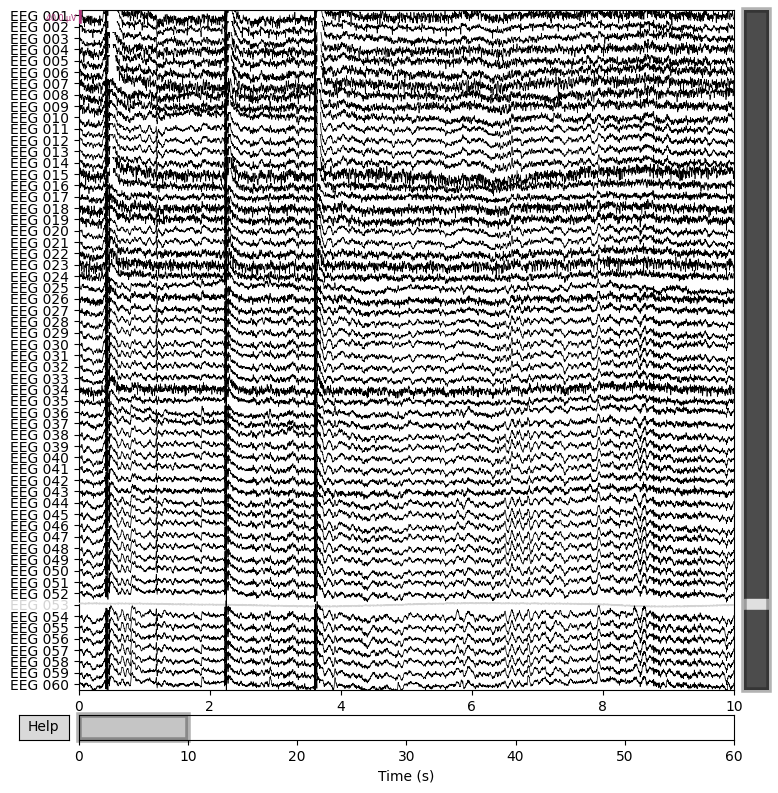

In [184]:
raw.plot(duration=10,n_channels=len(raw.ch_names));
# added ; to supress Jupyter's automatic output of the same plot 

In [185]:
def plot_psd_title(data, title):
    fig = data.compute_psd().plot()
    ax = fig.axes[0] 
    ax.set_title(f"{title} EEG PSD")
    plt.show()

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


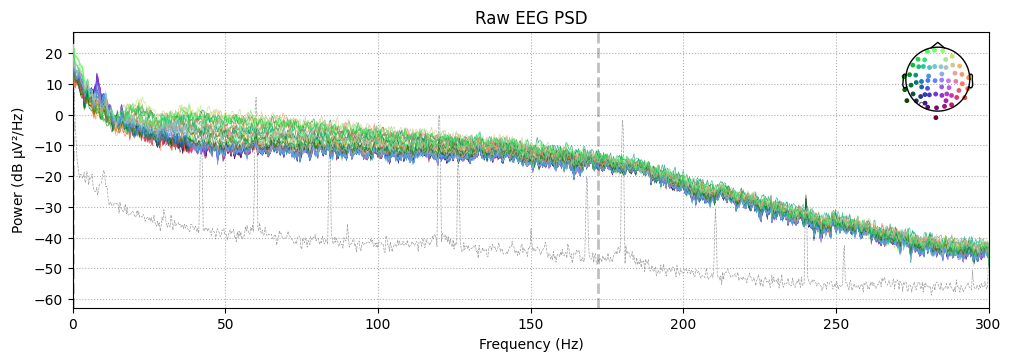

In [186]:
plot_psd_title(raw, "Raw")

### Remove Bad Channel Before Filtering

bads: ['EEG 053']
Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


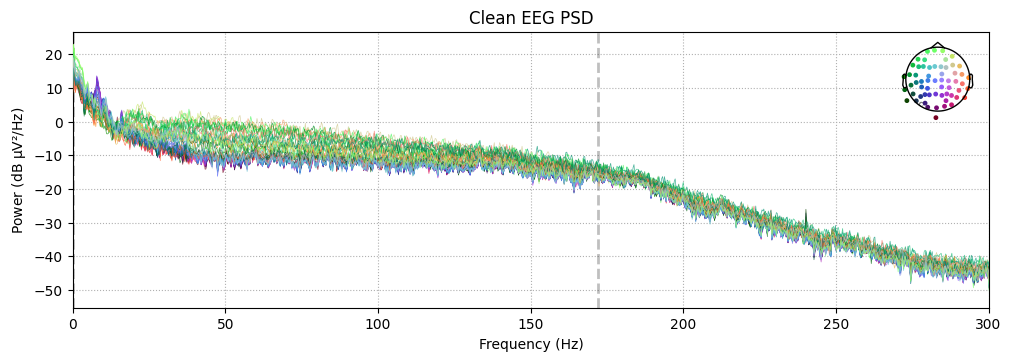

In [187]:
# remove bad channels (here is't 53 seen both in EEG plot and in PSD)

print("bads:", raw.info['bads'])
clean = raw.copy().interpolate_bads(reset_bads=False, verbose=False)
plot_psd_title(clean, "Clean")

### Define & Plot Butterworth Filter 

In [188]:
order = 4                   # butterworth order
low_pass_freq = 40 
f_p = low_pass_freq         # passband (cutoff) frequency 
sfreq =  raw.info["sfreq"]  # sampling freqency 
nyq = sfreq / 2.0           # the Nyquist frequency is half our sample rate
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]
flim = (1.0, sfreq / 2.0)   # frequencies
dlim = (-0.2, 0.2)          # delays
kwargs = dict(flim=flim, dlim=dlim)
h_freq = low_pass_freq      # high cutoff frequency 

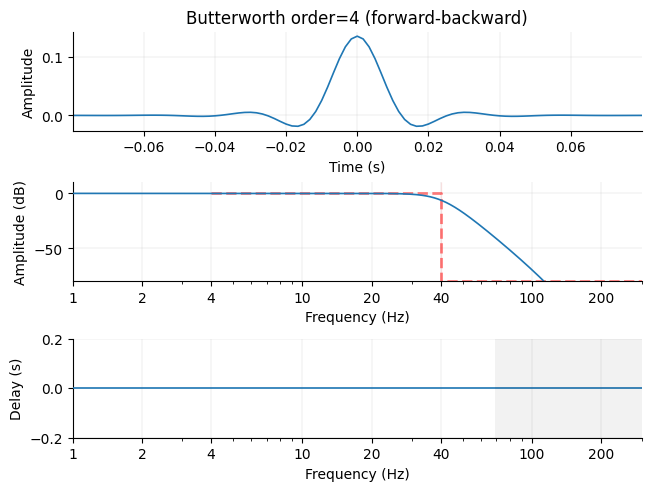

In [202]:
# plot filter for demonstration 
sos = signal.iirfilter(order, f_p / nyq, btype="low", ftype="butter", output="sos")
plot_filter(dict(sos=sos), sfreq, freq, gain, 
            f"Butterworth order={order}", compensate=True, **kwargs); 

* In the time domain (top), the filter has a symmetric impulse response that smooths the signal. Forward-backward filtering means that the filter is applined first forwarad and then in reverse, to cansle pahse delay. 
* The frequency domain (middle) shows how the filter reduces frequencies, starting at the cut off frequency - 40 Hz in our case. Frequencies below that are not affected and have 0 responces. Higher order of filtering whould have a sharper frequency cutoff. 
* There is no group delay (bottom plot), so all frequencies pass through the filter without being delayed in time, due to the forward-backward filtering. 

### Apply Butterworth Filter

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


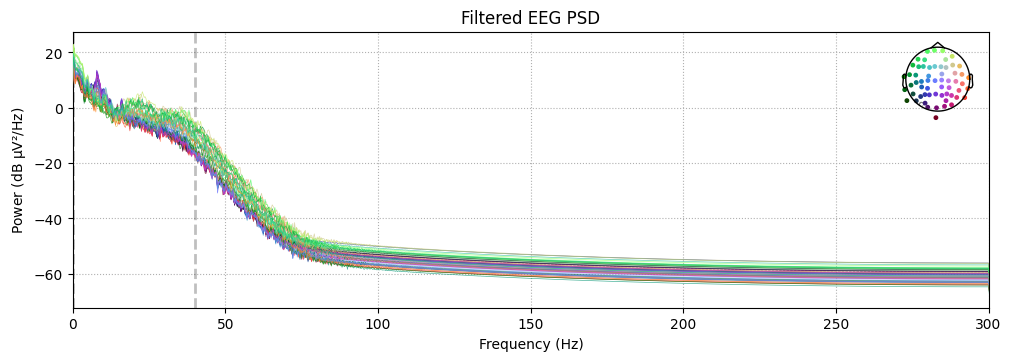

In [190]:
# using mne's butter filter
filtered = clean.filter(l_freq=None, h_freq=h_freq,  method='iir', 
                        iir_params=dict(ftype='butter', order=order))
plot_psd_title(filtered, "Filtered")

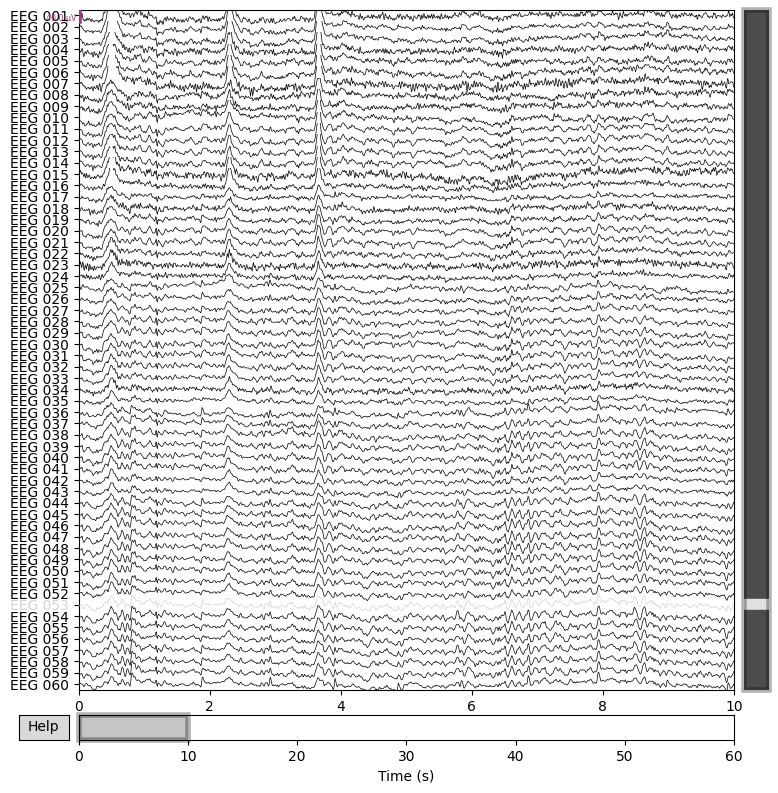

In [197]:
filtered.plot(duration=10,n_channels=len(filtered.ch_names));

### references

* [MNE data overview](https://mne.tools/dev/auto_tutorials/intro/10_overview.html)
* [MNE filtering](https://mne.tools/dev/auto_tutorials/preprocessing/25_background_filtering.html)
* [MATLAB filters to MNE](https://psymbio.github.io/posts/filters/)
* [change title of PSD figure](https://mne.discourse.group/t/adding-titles-to-psd-plots/2572/3)